# Exploratory Data Analysis - Crime Data Los Angeles

This notebook is used to explore the questions for the Data Scientist Exercise in July 2020.

- How else has reported crime changed over time in the City?
- Based on your analysis, please share any changes to services, programs, or policies that the City should consider.

##  Load libraries

In [2]:
# Import libraries
import os, sys, subprocess
import json
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')

In [3]:
# load project config
terminal_call = ! git rev-parse --show-toplevel
repo_path=terminal_call[0]
project_config_path = os.path.join(repo_path,'project_config.json')

with open(project_config_path,'r') as fp: 
    project_config = json.load(fp)

In [4]:
# import custom module to look at trends
module_path = os.path.join(repo_path,project_config['project_module_relative_path'])
sys.path.append(module_path)

import trends
from trends import get_top_trends as gt
from trends import convert
from trends.convert import crime_dict, mocode_dict, violent_crime_dict # load in crime name dictionary
from importlib import reload # for updating scripts

# Load in data

In [5]:
# load in data that was collected
df = pickle.load(open("../data/crime_data.pkl", "rb"))

In [6]:
# Explore summary info
def eda(df):
    nulls = pd.DataFrame(df.isnull().sum()).T # Check for nulls
    datatypes = pd.DataFrame(df.dtypes).T # Check datatypes
    summary = pd.concat([nulls, datatypes], keys = ["nulls", "datatypes"]) # Create pandas dataframe, because I think it's easier to read
    return summary

In [7]:
eda(df)

,,dr_no,date_rptd,date_occ,time_occ,area,area_name,rpt_dist_no,part_1-2,crm_cd,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_cd,premis_desc,weapon_used_cd,weapon_desc,status,status_desc,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,location,cross_street,lat,lon,year,mocodes_1,mocodes_2,mocodes_3
nulls,0,0,0,0,0,0,0,0,0,0,0,240361,0,208478,208527,55,228,1464999,1465000,3,0,11,2063105,2206364,2209991,0,1837686,0,0,0,0,0,0
datatypes,0,int64,datetime64[ns],datetime64[ns],int64,int64,object,int64,int64,int64,object,object,int64,object,object,float64,object,float64,object,object,object,float64,float64,float64,float64,object,object,float64,float64,int64,int64,int64,int64


## How else has reported crime changed over time in the City?

In [8]:
total_crimes = pd.DataFrame(df.groupby("year").size().reset_index(name ="total_cases"))

In [9]:
total_crimes.set_index("year", inplace = True)
total_crimes.head()

,total_cases
year,
2010,200536
2011,197858
2012,200110
2013,192146
2014,194966


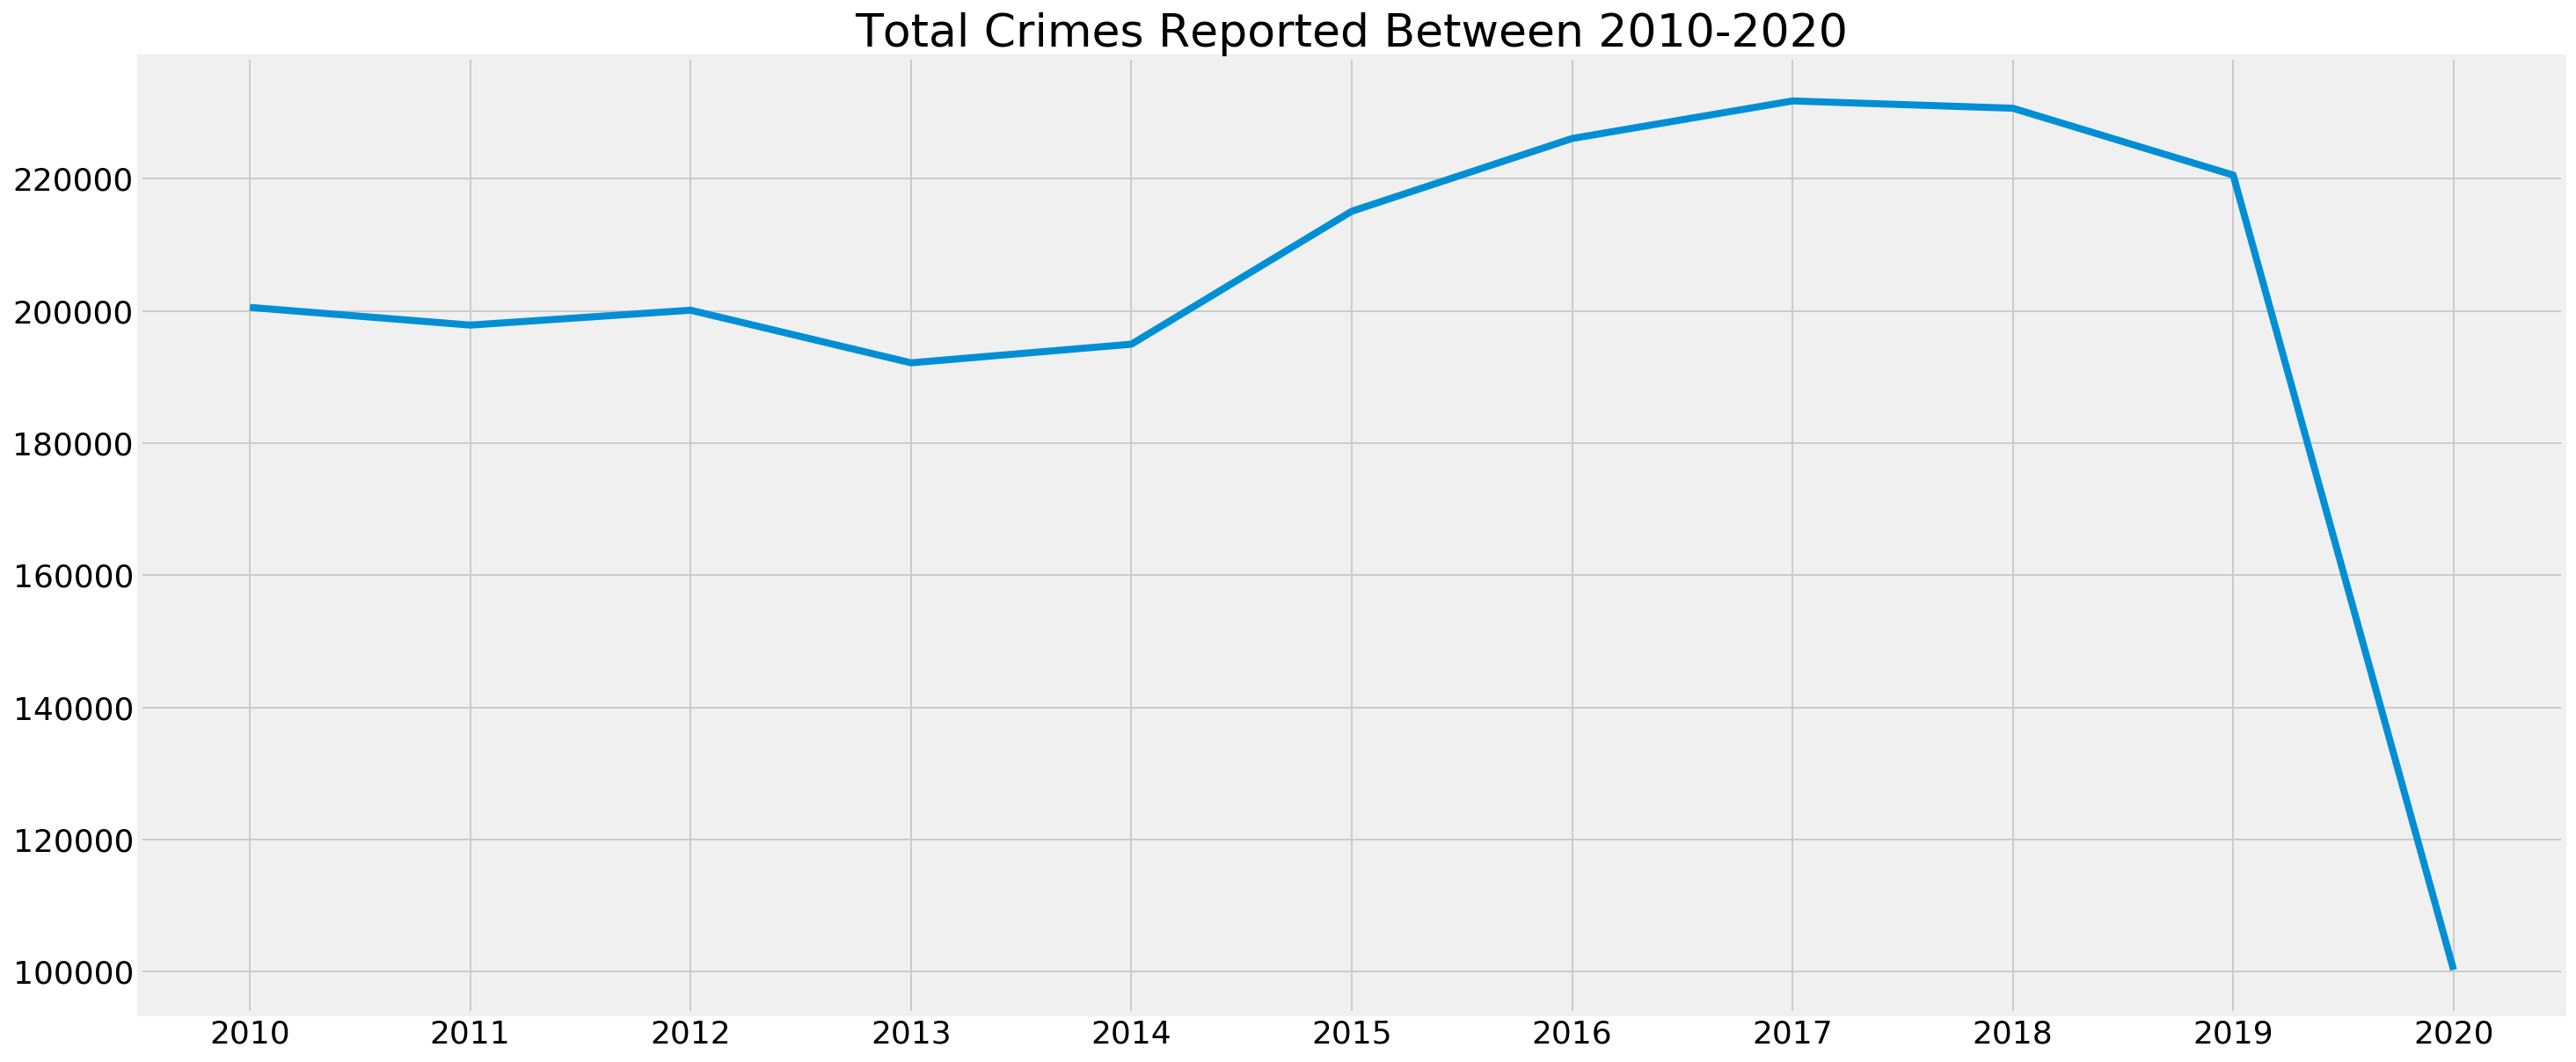

In [10]:
# Generate a time plot of our data.
gt.plot_series(total_crimes,
            ['total_cases'],
            title = 'Total Crimes Reported Between 2010-2020',
            steps = 1);

## Calculate rolling means for daily crimes reported

In [11]:
# calculate rolling means for the number of crimes reported each day

#group by date
crimes = pd.DataFrame(df.groupby("date_rptd").size().reset_index(name ="total_cases"))
crimes.set_index("date_rptd", inplace = True)

In [12]:
# rolling mean for 1 month
crimes["rolling_mean_month"] = crimes["total_cases"].rolling(30).mean()

# quarterly rolling mean
crimes["rolling_mean_quarter"] = crimes["total_cases"].rolling(120).mean()

# annual rolling mean
crimes["rolling_mean_annual"] = crimes["total_cases"].rolling(365).mean()

/opt/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


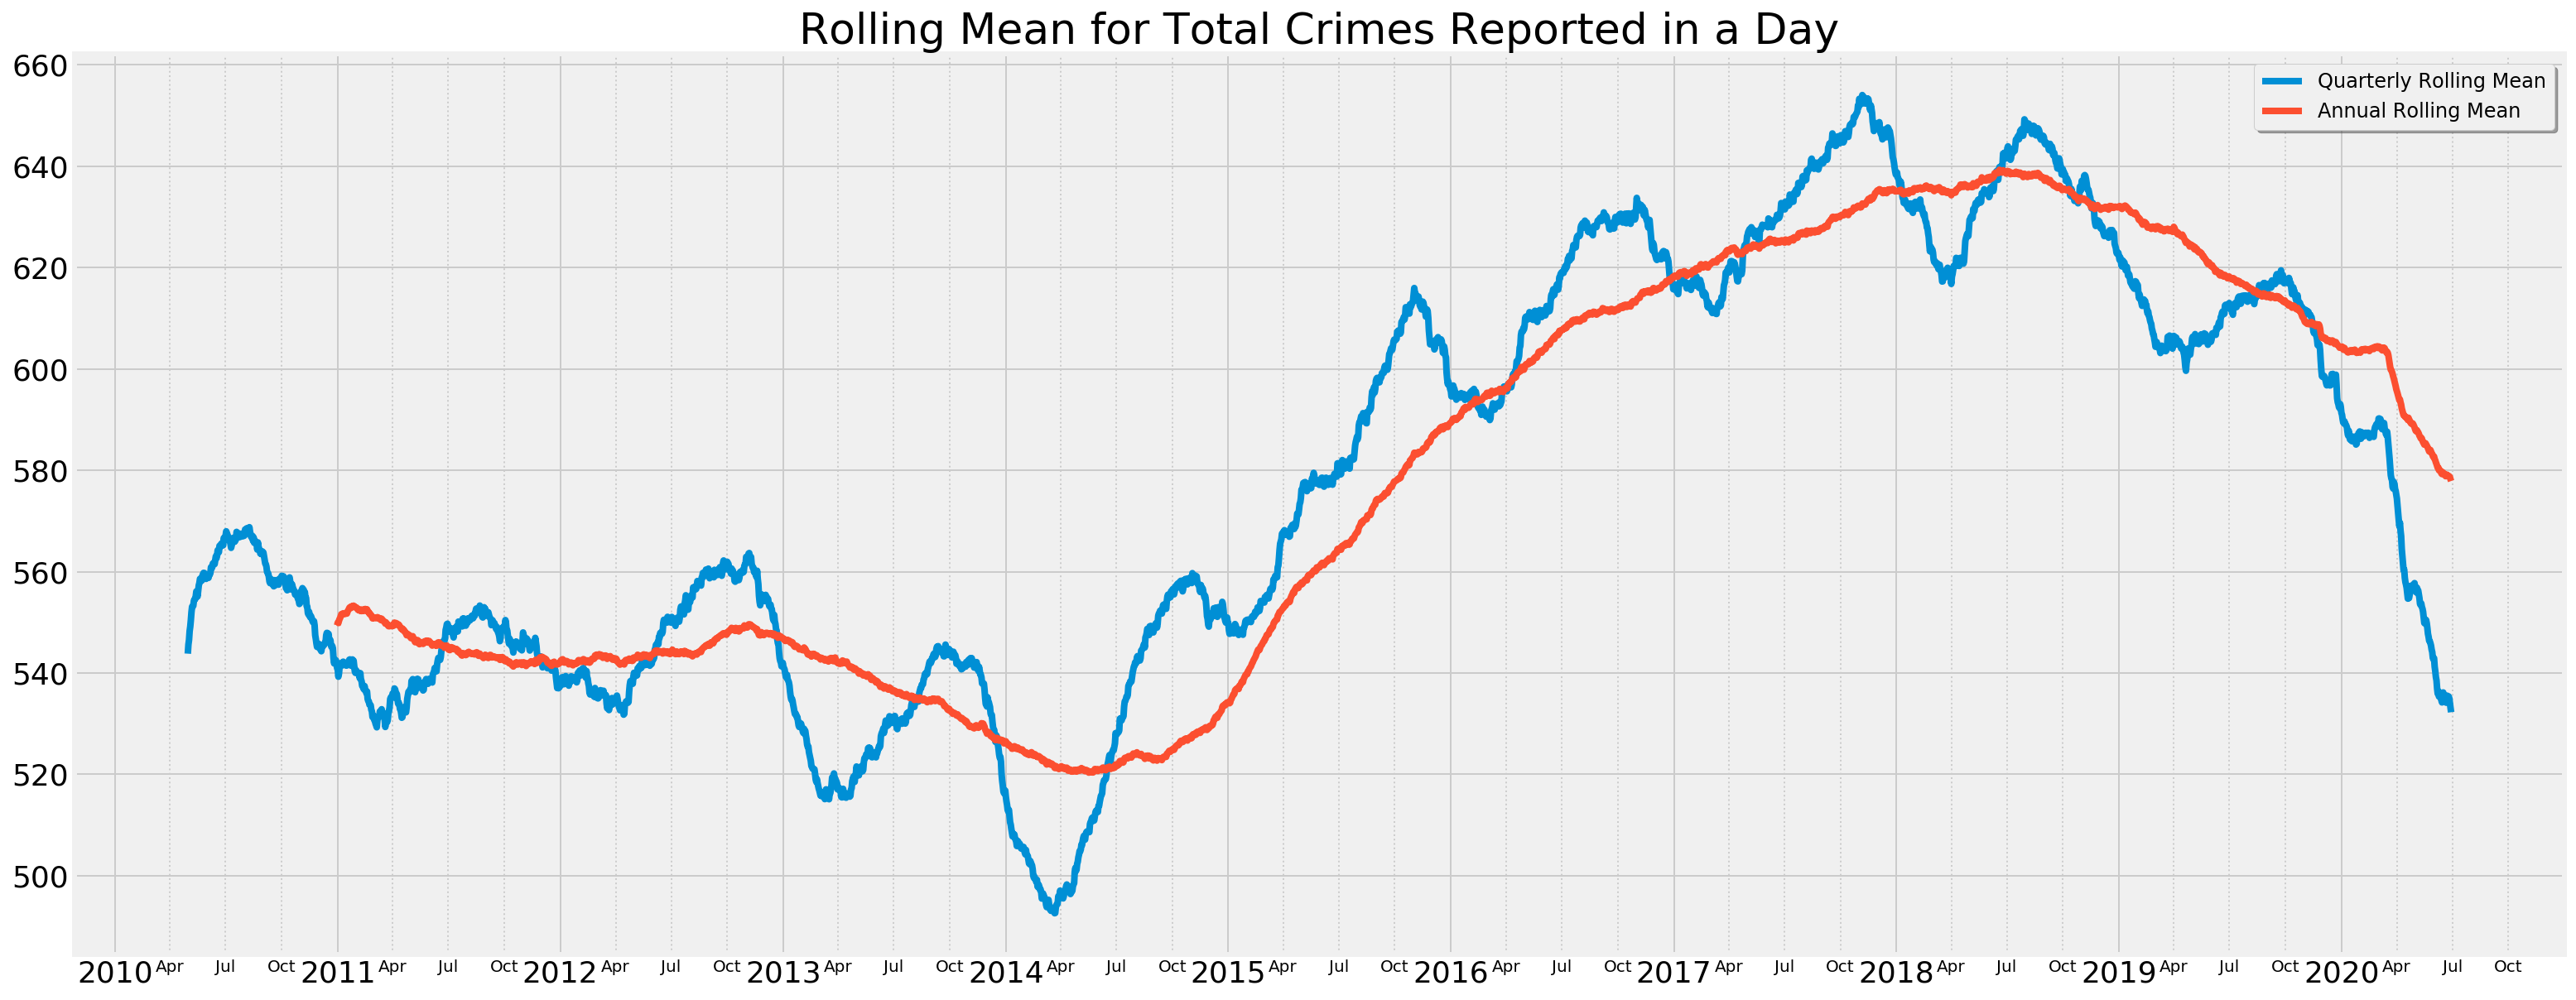

In [13]:
gt.plot_rolling_series(crimes, ["rolling_mean_quarter", "rolling_mean_annual"], 
                    title='Rolling Mean for Total Crimes Reported in a Day')

plt.legend(labels = ["Quarterly Rolling Mean", "Annual Rolling Mean"], loc='upper right',
          fancybox=True, shadow=True, fontsize = 12);

# plt.savefig('../plots/daily_reports_rolling_means.eps', format='eps', dpi=72)

## Are the crimes getting more serious over the years?

According to the datasource, lower crime class numbers are more serious [source](https://data.lacity.org/A-Safe-City/Crime-Data-from-2020-to-Present/2nrs-mtv8). 
Looking at the UCR Crime codes [here](https://data.lacity.org/api/views/63jg-8b9z/files/fff2caac-94b0-4ae5-9ca5-d235b19e3c44?download=true&filename=UCR-COMPSTAT062618.pdf), I created a dictionary of all the violent crime codes.

In [ ]:
# create a column that checks if the crime is violent
df["is_violent"]= [i in violent_crime_dict.keys() for i in df["crm_cd"]]

In [ ]:
# calculate the % of violent crimes each year and area
violent_crimes = (df.groupby(["year", "area", "area_name"])["is_violent"].sum()/df.groupby(["year", "area"]).size()).reset_index(name="percent_violent")

In [ ]:
# only select for year 2010 and 2020
violent_crimes = violent_crimes[(violent_crimes["year"]== 2010) | (violent_crimes["year"]== 2020)]

In [ ]:
# conditional color. Color red if the % violent crime increased over the 10 years
highlight = ['#ff3700' if (violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[1] > violent_crimes[violent_crimes["area"] == i]["percent_violent"].values[0]) else "#323232" for i in violent_crimes["area"]]

In [ ]:
violent_crimes.head()

In [ ]:
g = sns.FacetGrid(violent_crimes, col="area_name", col_wrap=5, height=3, sharex=False)
g = (g.map(plt.plot, "year", "percent_violent", marker=".")).set(ylim=(0,.5), yticks=[.25,.5], xlim=(2010, 2020), xticks=[2010, 2020])
#g.set_xlabels([2010,2020], fontsize=10)
g.set_ylabels("% violent crimes", fontsize=10)
g.set_xlabels("")
g.set_titles("{col_name}")
#g.set_yticklabels(labels=[.25,.5], size=10)
#g.set_xticklabels(labels = [2010,"", "", "", "", 2020], size=10);


# customize color on conditional. If the % of violent crimes has increased over the years, color red. 
for i in np.arange(0,21):
    (g.facet_axis(0,i)).get_lines()[0].set_color(highlight[i])
    

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Trend in % Violent Crimes by LAPD Area 2010-2020', fontsize=20)

plt.savefig('../plots/violent_crimes_area.eps', format='eps', dpi=72)

## What's the status of these crimes

In [ ]:
# Checking to see what the status is of all these crimes
df["status_desc"].value_counts()

In [ ]:
# Checking to see how many reported crimes are still open per year
df[df["status"]=="IC"].groupby("year")["status"].value_counts()

In [ ]:
# What's the % of cases that are still open?
open = df[df["status"] == "IC"].shape[0]/ df.shape[0]
print("{:.1%}".format(open) + " cases are still open.")

In [ ]:
# What's the % of cases that led to a juvenile arrest?
ja_cases = df[df["status"] == "JA"].shape[0]/ df[df["status"] != "IC"].shape[0]
print("{:.1%}".format(ja_cases) + " of all closed cases led to a juvenile arrest.")

## Explore cases that led to a juvenile arrest

In [ ]:
# segment dataframe for only the juvenile cases
ja = df[df["status"] == "JA"]

In [ ]:
# top crimes that led to a juvenile arrest
ja["crm_cd_desc"].value_counts(ascending = False).head(10)

In [ ]:
total_ja = pd.DataFrame(ja.groupby("year").size().reset_index(name ="total_cases"))
total_ja.set_index("year", inplace = True)

In [ ]:
# Generate a time plot of our data.

plot_series(total_ja,
            ['total_cases'],
            title = 'Total Juvenile Arrests Between 2010-2020',
            steps = 1);


ax = sns.scatterplot(x=2020, y="total_cases", data=total_ja.tail(1), legend=False,
                     color = "#000000",marker = "s" )

ax.set(ylabel="Total Number of Cases")

ax.text(2020+0.05, total_ja[total_ja.index==2020]["total_cases"],
             "2020 data only up to July 1", horizontalalignment='left', size =12);

# plt.savefig('../plots/juvenile_arrests.eps', format='eps', dpi=72)

### Overall, the number of juvenile arrests have been decreasing in the past decade. At a quick glance, this shows the possibility that the diversion policies are making a difference.

## Explore cases on domestic violence

Domestic Violence has consistently been one of the top MO's over the last 5 years. Let's explore which populations are most affected. From the MO codes listed [here](https://data.lacity.org/api/views/63jg-8b9z/files/3db69cd3-446c-4dcd-82eb-3436dc08d3be?download=true&filename=MO_CODES_Numerical_20180627.pdf), domestic violence is listed as 2000.

In [ ]:
# Filter dataframe for MO domestic violence
dv = df[df["mocodes_1"]==2000]

In [ ]:
dv["mocodes_2"].value_counts().head(10)

In [ ]:
dv["vict_age"].value_counts().head(10)

In [ ]:
dv["vict_descent"].value_counts()

In [ ]:
dv.groupby(["vict_age", "vict_sex", "vict_descent"]).size()

In [ ]:
dv.head()